In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
#from recsysNN_utils import *
pd.set_option("display.precision", 1)

2023-08-16 08:39:03.872609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 08:39:04.022148: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-08-16 08:39:04.022248: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-08-16 08:39:04.022435: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-1

## Content-based filtering with a neural network


<figure>
    <img src="RecSysNN.png"   style="width:500px;height:280px;" >
</figure>

```python
from numpy import genfromtxt

offers_train_ = genfromtxt('Offers_Train_Data.csv', delimiter=',')[:,2:]
user_train = genfromtxt('User_Train_Data.csv', delimiter=',')
y_train_    = genfromtxt('Conversions_Label_Train_data.csv', delimiter=',')

import pandas as pd
user_df = pd.DataFrame(user_train)
user_df[3] = user_df[3].fillna(
    user_df[3].quantile(0.5)
)
user_train = user_df.values
```

In [3]:
#user_df.head()

In [4]:
user_train_ = pd.read_csv("user_features.csv")
#user_train_.drop(
   # user_train_.index[user_train_.segment_id.isin(
       # ['ODellCaptivate_Livongo_Pre_Diabetes',
         #'ODellFindaPCPER',
         #'ODELL_OptimizeFinancialWellness_Older_highrisk'])], inplace=True)

In [5]:
pd.set_option('display.max_rows', None)
user_train_.isnull().sum()

person_id                                     0
client_id                                     0
impression_flag                               0
engagement_flag                               0
segment_id                                    0
eligibility_start_date                        0
eligibility_end_date                          0
conversion_id                            165702
conversion_flag                               0
conversion_description                   165745
one_yr_lookup_date                            0
num_unique_offers_engag_till_date             0
num_engag_till_date                           0
eligibility_year                              0
total_engagements_cust                        0
total_conversions_cust                        0
total_impression_cust                         0
unique_segments_engaged_cust                  0
avg_engagements_per_day_cust              52203
avg_engagements_per_conversion                0
avg_engagement_to_conversion_time       

In [6]:
user_train_.columns

Index(['person_id', 'client_id', 'impression_flag', 'engagement_flag',
       'segment_id', 'eligibility_start_date', 'eligibility_end_date',
       'conversion_id', 'conversion_flag', 'conversion_description',
       ...
       'EMP_STATUS_Enrolled_QDRO', 'EMP_STATUS_LOA_Family_Medical',
       'EMP_STATUS_LOA_Military', 'EMP_STATUS_LOA_No_Pay',
       'EMP_STATUS_LOA_With_Pay', 'EMP_STATUS_LOA_Workers_Compensation',
       'EMP_STATUS_Layoff', 'EMP_STATUS_Retired', 'EMP_STATUS_Severance_Pay',
       'EMP_STATUS_Termination'],
      dtype='object', length=132)

In [7]:
#user_train_['avg_engagements_per_day_cust'] = user_train_['avg_engagements_per_day_cust'].dropna()

In [8]:
# (user_train_.isnull().sum().to_frame())

In [9]:
# user_train_.dropna()

In [10]:
user_train_.shape

(233495, 132)

In [11]:
user_train_.head(1)

,person_id,client_id,impression_flag,engagement_flag,segment_id,eligibility_start_date,eligibility_end_date,conversion_id,conversion_flag,conversion_description,...,EMP_STATUS_Enrolled_QDRO,EMP_STATUS_LOA_Family_Medical,EMP_STATUS_LOA_Military,EMP_STATUS_LOA_No_Pay,EMP_STATUS_LOA_With_Pay,EMP_STATUS_LOA_Workers_Compensation,EMP_STATUS_Layoff,EMP_STATUS_Retired,EMP_STATUS_Severance_Pay,EMP_STATUS_Termination
0,10032.0,5977,1,1,ODellNewHireEnrl,2021-08-05 00:08:00,2021-08-11 00:00:00,CODellNewHireEnrl,1,Convert: Enroll in your Dell health and insura...,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#np.sum((user_train_.values != user_train).astype(int))

In [13]:
#user_train = user_train.sample(n=len(user_train)).reset_index(drop=True)

#user_train.shape

In [14]:
# pip install awswrangler

In [15]:
offers_train_ = pd.read_csv("offers_train_csv.csv")

In [16]:
offers_train_.head()

,segment_id,Description,Clinical_No,Clinical_Yes,Campaign_Access diabetes support,Campaign_Annual Enrollment,Campaign_Family Matters,Campaign_Find a PCP,Campaign_Get help for high spend,Campaign_Keep up with preventive care,...,Campaign_Use Benefits Wisely,Campaign_Welcome to Navigation,"Offer_Group_Alight_Financial_Path,_Wealth_Essentials_+",Offer_Group_Annual_Enrollment,Offer_Group_Health_Custom,Offer_Group_Navigation,Offer_Group_New_Hire,avg_eligible_ppts_per_year,avg_ppts_engaged_per_year,unique_customers_engaged_seg
0,ODellNewHireEnrl,New Hire - Enroll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,164.0,163.7,586.0
1,ODellNewHireEnrl,New Hire - Enroll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,164.0,163.7,586.0
2,ODellNewHireEnrl,New Hire - Enroll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,164.0,163.7,586.0
3,O0006,Preventive Annual Physical,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,396.5,161.5,2767.0
4,O0006,Preventive Annual Physical,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,396.5,161.5,2767.0


In [17]:
offers_train_.isnull().sum()

segment_id                                                   0
Description                                               6857
Clinical_No                                               6857
Clinical_Yes                                              6857
Campaign_Access diabetes support                          6857
Campaign_Annual Enrollment                                6857
Campaign_Family Matters                                   6857
Campaign_Find a PCP                                       6857
Campaign_Get help for high spend                          6857
Campaign_Keep up with preventive care                     6857
Campaign_Manage cancer                                    6857
Campaign_Maximize financial wellbeing                     6857
Campaign_Mitigate MSK                                     6857
Campaign_New Hire                                         6857
Campaign_Pregnancy                                        6857
Campaign_Prioritize mental health                      

In [18]:
# offers_train_ = offers_train_.drop("unique_customers_engaged_seg",axis =1)

In [19]:
offers_train_.shape

(233495, 27)

In [20]:
offers_train_.head(2)

,segment_id,Description,Clinical_No,Clinical_Yes,Campaign_Access diabetes support,Campaign_Annual Enrollment,Campaign_Family Matters,Campaign_Find a PCP,Campaign_Get help for high spend,Campaign_Keep up with preventive care,...,Campaign_Use Benefits Wisely,Campaign_Welcome to Navigation,"Offer_Group_Alight_Financial_Path,_Wealth_Essentials_+",Offer_Group_Annual_Enrollment,Offer_Group_Health_Custom,Offer_Group_Navigation,Offer_Group_New_Hire,avg_eligible_ppts_per_year,avg_ppts_engaged_per_year,unique_customers_engaged_seg
0,ODellNewHireEnrl,New Hire - Enroll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,164.0,163.7,586.0
1,ODellNewHireEnrl,New Hire - Enroll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,164.0,163.7,586.0


In [21]:
offers_train_ = offers_train_.dropna()

In [22]:
offers_train_.isnull().sum()

segment_id                                                0
Description                                               0
Clinical_No                                               0
Clinical_Yes                                              0
Campaign_Access diabetes support                          0
Campaign_Annual Enrollment                                0
Campaign_Family Matters                                   0
Campaign_Find a PCP                                       0
Campaign_Get help for high spend                          0
Campaign_Keep up with preventive care                     0
Campaign_Manage cancer                                    0
Campaign_Maximize financial wellbeing                     0
Campaign_Mitigate MSK                                     0
Campaign_New Hire                                         0
Campaign_Pregnancy                                        0
Campaign_Prioritize mental health                         0
Campaign_RX compliance                  

In [23]:
# (offers_train_.isnull().sum())

In [24]:
offers_train_.shape

(226638, 27)

In [25]:
# offers_train_.columns

In [26]:
# offers_train_[~offers_train_.segment_id.isin(user_train_.segment_id.unique())].segment_id.unique()

In [27]:
user_train_.drop(user_train_.index[~user_train_.segment_id.isin(offers_train_.segment_id.unique())], inplace=True)

In [28]:
user_train_.reset_index(drop=True, inplace=True)

In [29]:
# user_train_.shape

In [30]:
# offers_train_.describe

In [31]:
user_train_.shape

(226638, 132)

In [32]:
# offers_train_1 = offers_train_.values

In [33]:
# offers_train_1

In [34]:
# user_train_.columns

In [35]:
#y_train_ = user_train_.engagement_flag.values
offers_train_ = offers_train_.drop(["segment_id","Description"],axis = 1)
offers_train_ = offers_train_.values

# offers_train_ = (
#     user_train_[["segment_id"]].merge(offers_train_,on="segment_id")
#     .drop(["segment_id","Description"], axis=1)
# ).values

In [36]:
offers_train_.shape

(226638, 25)

In [37]:
user_train_ = user_train_.drop(["person_id","client_id","eligibility_end_date","conversion_description","conversion_id",
                                     "segment_id","eligibility_start_date","one_yr_lookup_date", 
                                "segment_id"], axis=1)


In [38]:
# y_train_ = user_train_.conversion_flag.values

# offers_train_ = (
#     user_train_[["segment_id"]].merge(offer_features, how="left", on="segment_id")
#     .drop(["segment_id","Description"], axis=1)
# ).values

In [39]:
offers_train_.shape

(226638, 25)

In [40]:
# offers_train_[np.isnan(offers_train_)]

In [41]:
# user_train_ = user_train_.drop(["data_source_clientid","data_source_personid",
#                               "person_internal_id", "client_id",
#                               "segment_id","eligibility_start_date",
#                               "one_yr_lookup_date","conversion_flag"], axis=1)

In [42]:
user_train_.shape

(226638, 124)

In [43]:
user_train_.isnull().sum()

impression_flag                               0
engagement_flag                               0
conversion_flag                               0
num_unique_offers_engag_till_date             0
num_engag_till_date                           0
eligibility_year                              0
total_engagements_cust                        0
total_conversions_cust                        0
total_impression_cust                         0
unique_segments_engaged_cust                  0
avg_engagements_per_day_cust              49722
avg_engagements_per_conversion                0
avg_engagement_to_conversion_time        179163
engagement_rate                               0
age                                           0
base_pay_regular_expectedannualsalary         0
ST_AA                                         0
ST_AB                                         0
ST_AE                                         0
ST_AK                                         0
ST_AL                                   

In [44]:
# user_train_.columns

In [45]:
user_train_.fillna(0, inplace=True)

In [46]:
y_train_ = user_train_.engagement_flag.values
user_train_.drop("engagement_flag", axis=1, inplace=True)

In [47]:
columns_index = {k:v for v,k in enumerate(user_train_.columns)}

In [48]:
# avg_engagements_per_day_cust

In [49]:
features_dict = \
{
    "features_list_1":["num_unique_offers_engag_till_date","num_engag_till_date","unique_segments_engaged_cust",
                       "engagement_rate"],
    "features_list_2":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","age"],
    "features_list_3":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","total_impression_cust","age",
                       "base_pay_regular_expectedannualsalary"],
    "features_list_4":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","total_impression_cust",
                       "avg_engagements_per_day_cust","engagement_rate","total_conversions_cust",
                       "num_engag_till_date","avg_engagement_to_conversion_time",
                       "base_pay_regular_expectedannualsalary"],
    "features_list_5":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","total_impression_cust",
                       "avg_engagements_per_day_cust","engagement_rate","total_conversions_cust",
                       "num_engag_till_date","avg_engagement_to_conversion_time","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN'],
    "features_list_5":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","total_impression_cust",
                       "avg_engagements_per_day_cust","engagement_rate","total_conversions_cust",
                       "num_engag_till_date","avg_engagement_to_conversion_time","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN'],
     "features_list_6":["num_unique_offers_engag_till_date","avg_engagements_per_conversion",
                       "unique_segments_engaged_cust","total_engagements_cust","total_impression_cust",
                       "avg_engagements_per_day_cust","engagement_rate","total_conversions_cust",
                       "num_engag_till_date","avg_engagement_to_conversion_time","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN','EMP_STATUS_Active', 
                        'EMP_STATUS_COBRA_Dependent', 'EMP_STATUS_COBRA_Employee',
                        'EMP_STATUS_DNM', 'EMP_STATUS_Deceased_In_Service', 
                        'EMP_STATUS_Deceased_Outofservice', 
                        'EMP_STATUS_Disability_Long_Term', 
                        'EMP_STATUS_Disability_Short_Term',
                        'EMP_STATUS_Enrolled_Beneficiary', 
                        'EMP_STATUS_Enrolled_QDRO', 
                        'EMP_STATUS_LOA_Family_Medical', 
                        'EMP_STATUS_LOA_Military', 'EMP_STATUS_LOA_No_Pay', 
                        'EMP_STATUS_LOA_With_Pay', 
                        'EMP_STATUS_LOA_Workers_Compensation', 
                        'EMP_STATUS_Layoff', 'EMP_STATUS_Retired', 
                        'EMP_STATUS_Severance_Pay', 'EMP_STATUS_Termination'],
    "features_list_7":user_train_.columns.tolist()
}
 

In [50]:
user_train_.head(2)

,impression_flag,conversion_flag,num_unique_offers_engag_till_date,num_engag_till_date,eligibility_year,total_engagements_cust,total_conversions_cust,total_impression_cust,unique_segments_engaged_cust,avg_engagements_per_day_cust,...,EMP_STATUS_Enrolled_QDRO,EMP_STATUS_LOA_Family_Medical,EMP_STATUS_LOA_Military,EMP_STATUS_LOA_No_Pay,EMP_STATUS_LOA_With_Pay,EMP_STATUS_LOA_Workers_Compensation,EMP_STATUS_Layoff,EMP_STATUS_Retired,EMP_STATUS_Severance_Pay,EMP_STATUS_Termination
0,1,1,0,0,2021,3,2,3,3,8.3e-02,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,2021,3,2,3,3,8.3e-02,...,0,0,0,0,0,0,0,0,0,0


In [51]:
new_feataures_dict = features_dict.copy()
for k,v in features_dict.items():
    new_feataures_dict[k] = [columns_index[col] for col in v]

In [52]:
new_feataures_dict

{'features_list_1': [2, 3, 8, 12],
 'features_list_2': [2, 10, 8, 5, 13],
 'features_list_3': [2, 10, 8, 5, 7, 13, 14],
 'features_list_4': [2, 10, 8, 5, 7, 9, 12, 6, 3, 11, 14],
 'features_list_5': [2, 10, 8, 5, 7, 9, 12, 6, 3, 11, 13, 14, 95, 96, 97],
 'features_list_6': [2,
  10,
  8,
  5,
  7,
  9,
  12,
  6,
  3,
  11,
  13,
  14,
  95,
  96,
  97,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122],
 'features_list_7': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  8

In [53]:
user_train_ = user_train_.values

In [54]:
print(f"Number of training vectors: {len(offers_train_)}")

Number of training vectors: 226638


### Building the NN architecture

In [55]:
def create_model(l1, l2, num_outputs):

    tf.random.set_seed(1)
    user_NN = tf.keras.models.Sequential([
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l1, activation="relu", name="U1"),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l2, activation="relu", name="U2"),
        tf.keras.layers.Dense(num_outputs, activation="linear",
                              name="User_embeddings")
    ])

    offers_NN = tf.keras.models.Sequential([
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l1, activation="relu", name="M1"),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l2, activation="relu", name="M2"),
        tf.keras.layers.Dense(num_outputs, activation="linear",
                              name="Offers_embeddings")  
    ])

    # create the user input and point to the base network
    input_user = tf.keras.layers.Input(shape=(num_user_features))
    vu = user_NN(input_user)
    vu = tf.linalg.l2_normalize(vu, axis=1)

    # create the offers input and point to the base network
    input_offers = tf.keras.layers.Input(shape=(num_offers_features))
    vm = offers_NN(input_offers)
    vm = tf.linalg.l2_normalize(vm, axis=1)

    # compute the dot product of the two vectors vu and vm
    output = tf.keras.layers.Dot(axes=1)([vu, vm])
    # specify the inputs and output of the model
    model = tf.keras.Model([input_user, input_offers], output)
    
    cost_fn = tf.keras.losses.BinaryCrossentropy()
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=cost_fn)
    
    print(model.summary())
    
    return model

In [56]:
user_train_[:,new_feataures_dict["features_list_1"]]

array([[0., 0., 3., 1.],
       [0., 0., 3., 1.],
       [0., 0., 3., 1.],
       ...,
       [0., 0., 2., 0.],
       [1., 1., 2., 1.],
       [1., 1., 2., 0.]])

In [57]:
new_feataures_dict["features_list_1"]

[2, 3, 8, 12]

### Preparing the training data / Model Training

In [58]:
models_history = []

for key,value in new_feataures_dict.items():
    
    user_train = user_train_.copy()[:,value]
    # offers_train_ = offers_train_.copy()[:,value]
    
    X = pd.concat([pd.DataFrame(offers_train_), pd.DataFrame(user_train)], axis=1)
    
    # print("X",X.shape)
    # print("y_train_",len(y_train_))
    # print(f"Features List: {features_dict[key]}\n")
    
    num_user_features = user_train.shape[1] 
    num_offers_features = offers_train_.shape[1]

    print("Number of User Features: ", num_user_features)
    print("\n")
    print("Number of Offer Features: ", num_offers_features)
    print("\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_train_, 
                                                        test_size=0.9, 
                                                        shuffle=True, 
                                                        random_state=42)
    
    user_train = X_train.iloc[:,:num_user_features].values
    # print("user_train",user_train)
    
    offers_train = X_train.iloc[:,num_user_features:].values
    # print("offers_train",offers_train)
    
    user_test = X_test.iloc[:,:num_user_features].values
    offers_test = X_test.iloc[:,num_user_features:].values
 
    # print("user_test",user_test)
    # print("offers_test",offers_test)

    offers_train_unscaled = offers_train
    # print("a",offers_train_unscaled)
    user_train_unscaled = user_train

    scaleroffers = StandardScaler()
    scaleroffers.fit(offers_train)
    offers_train = scaleroffers.transform(offers_train)

    scalerUser = StandardScaler()
    scalerUser.fit(user_train)
    user_train = scalerUser.transform(user_train)

    offers_test = scaleroffers.transform(offers_test)
    user_test = scalerUser.transform(user_test)

    print("Offers_train_unscaled matches inverse transform: ", 
          np.allclose(offers_train_unscaled, 
                      scaleroffers.inverse_transform(offers_train)))
    
    print("User_train_unscaled matches inverse transform: ",
          np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))
    
    
    # Create Model
    l1, l2, num_outputs = 128, 64, 32
    model = create_model(l1, l2, num_outputs)
    
    tf.random.set_seed(1)
    with tf.device('/GPU:0'):
        training = model.fit([user_train, offers_train],
                             y_train,
                             batch_size=1024,
                             validation_data=([user_test, offers_test], 
                                              y_test), 
                             epochs=20)
    
    models_history.append(training)
    

Number of User Features:  4


Number of Offer Features:  25


Offers_train_unscaled matches inverse transform:  True
User_train_unscaled matches inverse transform:  True


2023-08-16 08:39:14.107370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 08:39:14.113540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 08:39:14.114162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 08:39:14.115489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate com

Extension horovod.torch has not been built: /usr/local/lib/python3.9/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-39-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.
[2023-08-16 08:39:15.230 tensorflow-2-10-1-g-ml-g4dn-xlarge-b79449e884a287b905b9fc5684f4:4088 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-08-16 08:39:15.460 tensorflow-2-10-1-g-ml-g4dn-xlarge-b79449e884a287b905b9fc5684f4:4088 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/usr/local/lib/python3.9/site-packages/smdebug-1.0.26b20230210-py3.9.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/usr/local/lib/python3.9/site-packages/smdebug-1.0.26b20230210-py3.9.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           10976       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           13664       ['input_2[0][0]']                
                                                                                              

In [59]:
# all_indices = np.where(offers_train_unscaled != scalerUser.inverse_transform(offers_train))

# print("List of some indices in user_train where the inverse transform dosen't match to offer_train_unscaled :\n")
# indices_list = []
# for r,c in zip(all_indices[0], all_indices[1]):
#     indices_list.append((r,c))
#     if r == 7: break
# print(indices_list)

# # user_train_inv_trans = scalerUser.inverse_transform(user_train)
# # for index in indices_list:
# #     print(f"Index {index}", user_train_unscaled[index[0],index[1]], user_train_inv_trans[index[0],index[1]])

ValueError: operands could not be broadcast together with shapes (22663,25) (123,) (22663,25) 

In [ ]:
models_history

In [ ]:
ax.shape

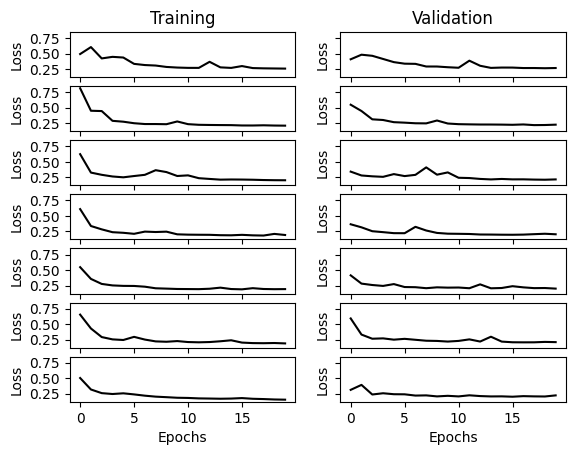

In [60]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(50,100))

fig, ax = plt.subplots(nrows=len(models_history), ncols=2, sharey=True)

#for i,training in enumerate(models_history):

ax[0][0].set(title="Training")
ax[0][0].plot(models_history[0].history['loss'], color='black')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('Loss', color='black')


ax[0][1].set(title="Validation")
ax[0][1].plot(models_history[0].history['val_loss'], color='black')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Loss', color='black')

ax[1][0].plot(models_history[1].history['loss'], color='black')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('Loss', color='black')


ax[1][1].plot(models_history[1].history['val_loss'], color='black')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Loss', color='black')

ax[2][0].plot(models_history[2].history['loss'], color='black')
ax[2][0].set_xlabel('Epochs')
ax[2][0].set_ylabel('Loss', color='black')


ax[2][1].plot(models_history[2].history['val_loss'], color='black')
ax[2][1].set_xlabel('Epochs')
ax[2][1].set_ylabel('Loss', color='black')

ax[3][0].plot(models_history[3].history['loss'], color='black')
ax[3][0].set_xlabel('Epochs')
ax[3][0].set_ylabel('Loss', color='black')


ax[3][1].plot(models_history[3].history['val_loss'], color='black')
ax[3][1].set_xlabel('Epochs')
ax[3][1].set_ylabel('Loss', color='black')

ax[4][0].plot(models_history[4].history['loss'], color='black')
ax[4][0].set_xlabel('Epochs')
ax[4][0].set_ylabel('Loss', color='black')


ax[4][1].plot(models_history[4].history['val_loss'], color='black')
ax[4][1].set_xlabel('Epochs')
ax[4][1].set_ylabel('Loss', color='black')

ax[5][0].plot(models_history[5].history['loss'], color='black')
ax[5][0].set_xlabel('Epochs')
ax[5][0].set_ylabel('Loss', color='black')


ax[5][1].plot(models_history[5].history['val_loss'], color='black')
ax[5][1].set_xlabel('Epochs')
ax[5][1].set_ylabel('Loss', color='black')

ax[6][0].plot(models_history[6].history['loss'], color='black')
ax[6][0].set_xlabel('Epochs')
ax[6][0].set_ylabel('Loss', color='black')


ax[6][1].plot(models_history[6].history['val_loss'], color='black')
ax[6][1].set_xlabel('Epochs')
ax[6][1].set_ylabel('Loss', color='black')
    #plt.tight_layout()
plt.show();

In [ ]:


# print("user_test",user_test)
# print("offers_test",offers_test)

offers_train_unscaled = offers_train
print("a",offers_train_unscaled)
user_train_unscaled = user_train

scaleroffers = StandardScaler()
scaleroffers.fit(offers_train)
offers_train = scaleroffers.transform(offers_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)


print("Offers_train_unscaled matches inverse transform: ", 
      np.allclose(offers_train_unscaled, 
                  scaleroffers.inverse_transform(offers_train)))

print("User_train_unscaled matches inverse transform: ",
      np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))